In [ ]:
# Use this cell to clone the repo and download pretrained models

!git clone git@github.com:fedegonzal/most-dinov2.git
!mv most-dinov2/* .
!rm -rf most-dinov2

# Download pretrained models
!wget https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth
!wget https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth
!wget https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth

!mv *.pth models/


In [ ]:
#############################
# DON'T NEED TO RUN THIS CELL
#############################

# Because sometimes I change the classes code and I want to reload it

from importlib import reload

import dinov2.models.vision_transformer
reload(dinov2.models.vision_transformer)

import dinov1.vision_transformer
reload(dinov1.vision_transformer)

import object_discovery
reload(object_discovery)


In [1]:
# I defined this class just to simulare args passed as a command line argument
# Some other arguments are set later in the notebook

class Args:
    def __init__(self):
        self.patch_size = None # will be set later
        self.image_path = None # will be set later
        self.img_size = None
        
        self.k_patches = 100
        self.dbscan_eps = 2
        self.ks = [1, 2]
        self.which_features = 'k'

# Create an instance of the class
args = Args()


In [2]:
######################################
# CHOOSE THE MODEL AND PATCH SIZE HERE
# ALSO SET THE IMAGE PATH TO ANALYZE
######################################

args.model = "DINOv1"
#args.model = "DINOv2"
#args.model = "DINOv2-reg4"

args.patch_size = 16 # DINOv1
#args.patch_size = 14 # DINOv2

args.image_path = 'images/dog-frisbee.jpg' # More images in the images folder



# /////////////////////////////////////

import torch

# will force cpu because compatibility issues
# the script is fast anyway
device = torch.device('cpu')



# Loading DINO v1 model
if args.model == "DINOv1":
    from dinov1.vision_transformer import vit_small

    model = vit_small(
            patch_size=args.patch_size,
            init_values=1.0,
            block_chunks=0
    )

    checkpoint = torch.load('pretrained/dino_deitsmall16_pretrain.pth', map_location=device)


# Loading DINO v2 model (without register tokens)
if args.model == "DINOv2":
    from dinov2.models.vision_transformer import vit_small

    args.img_size = 526

    model = vit_small(
        patch_size=args.patch_size,
        img_size=args.img_size,
        init_values=1.0,
        block_chunks=0
    )

    checkpoint = torch.load('pretrained/dinov2_vits14_pretrain.pth', map_location=device)


# Loading DINO v2 model (fixed with register tokens)
if args.model == "DINOv2-reg4":
    from dinov2.models.vision_transformer import vit_small

    args.img_size = 526

    model = vit_small(
        patch_size=args.patch_size,
        img_size=args.img_size,
        init_values=1.0,
        block_chunks=0
    )

    # fixed dino v2 with register tokens
    checkpoint = torch.load('pretrained/dinov2_vits14_reg4_pretrain.pth', map_location=device)
    del checkpoint['register_tokens'] # we don't need this and will cause an error on most



# The following code is the same for all models

for p in model.parameters():
    p.requires_grad = False

state_dict = model.load_state_dict(checkpoint)

model.eval()
model.to(device)

print("Model loaded")



/Users/fedegonzal/Documents/ub/most-dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/fedegonzal/Documents/ub/most-dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/fedegonzal/Documents/ub/most-dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


In [3]:
# Load and transform the selected image

from PIL import Image
import torchvision.transforms as T

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ]
)

image = Image.open(args.image_path).convert('RGB')
image = transform(image).to(device)


In [4]:
# Padding the image with zeros to fit multiple of patch-size

import numpy as np

new_image_container = (
    image.shape[0],
    int(np.ceil(image.shape[1] / args.patch_size) * args.patch_size),
    int(np.ceil(image.shape[2] / args.patch_size) * args.patch_size),
)
image_paded = torch.zeros(new_image_container)
image_paded[:, : image.shape[1], : image.shape[2]] = image

# Move to device
image_paded = image_paded.to(device)

# Size for transformers
w_featmap = image_paded.shape[-2] // args.patch_size
h_featmap = image_paded.shape[-1] // args.patch_size


In [5]:
# Gettin the features from the last attention layer!

with torch.no_grad():

    # Store the outputs of qkv layer from the last attention layer
    feat_out = {}

    def hook_fn_forward_qkv(module, input, output):
        feat_out["qkv"] = output

    model._modules["blocks"][-1]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)

    # Forward pass in the model
    attentions = model.get_last_selfattention(image_paded[None, :, :, :])

    # Scaling factor
    scales = [args.patch_size, args.patch_size]

    # Dimensions
    nb_im = attentions.shape[0]  # Batch size
    nh = attentions.shape[1]  # Number of heads
    nb_tokens = attentions.shape[2]  # Number of tokens

    # Extract the qkv features of the last attention layer
    qkv = (
        feat_out["qkv"]
        .reshape(nb_im, nb_tokens, 3, nh, -1 // nh)
        .permute(2, 0, 3, 1, 4)
    )

    q, k, v = qkv[0], qkv[1], qkv[2]
    k = k.transpose(1, 2).reshape(nb_im, nb_tokens, -1)
    q = q.transpose(1, 2).reshape(nb_im, nb_tokens, -1)
    v = v.transpose(1, 2).reshape(nb_im, nb_tokens, -1)
    
    # Modality selection
    if args.which_features == "k":
        feats = k[:, 1:, :]
    elif args.which_features == "q":
        feats = q[:, 1:, :]
    elif args.which_features == "v":
        feats = v[:, 1:, :]


In [6]:
print(feats.shape)
print(attentions.shape)
print(image_paded.shape)
print(image.shape)

torch.Size([1, 1290, 384])
torch.Size([1, 6, 1291, 1291])
torch.Size([3, 420, 602])
torch.Size([3, 420, 600])


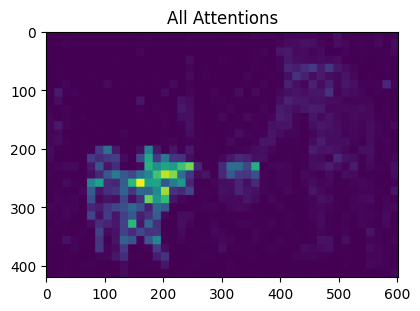

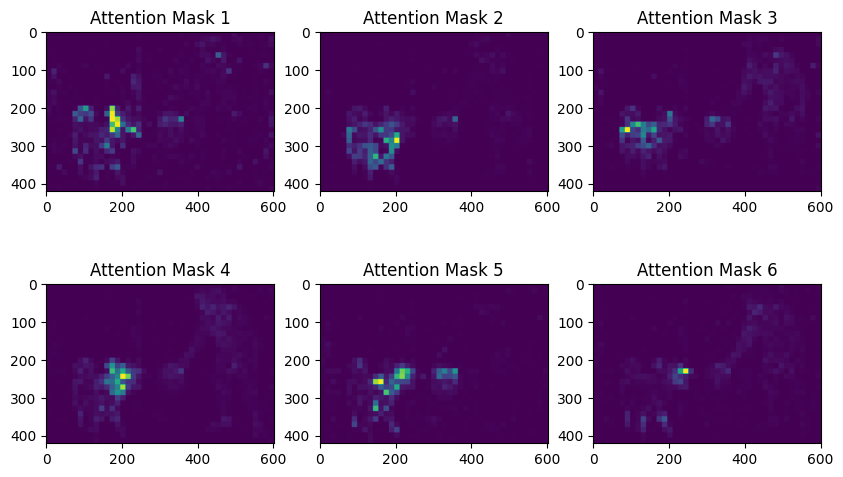

In [7]:
###############################
# HOW THE ATTENTION LOOKS LIKE?
###############################

import matplotlib.pyplot as plt
import math
import torch.nn as nn




# we keep only the output patch attention
# for every patch
atts = attentions[0, :, 0, 1:].reshape(nh, -1)
atts[:, 283] = 0 

atts = atts.reshape(nh, w_featmap, h_featmap)

# resize to image size
atts = nn.functional.interpolate(atts.unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0].cpu().detach().numpy()



# sum up all the attentions into one map
sum_attentions = sum(atts)

# Display the image and mask
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 2)
plt.imshow(sum_attentions)
plt.title("All Attentions")

plt.show()


# Individual attention maps

cols = 3
rows = math.ceil(atts.shape[0] / cols)

plt.figure(figsize=(10, cols*rows))

for i, att in enumerate(atts):
    plt.subplot(rows, cols, i+1)
    plt.imshow(att)
    plt.title("Attention Mask {}".format(i+1))

plt.show()


In [8]:
from object_discovery import most

# Getting mask

most_result = most(feats, [w_featmap, h_featmap], scales, image.shape,
    k_patches=args.k_patches, dbscan_eps=args.dbscan_eps,
    return_mask = True, ks=args.ks
)

preds, A, seed, others = most_result


entropy min mean max std
10.242091178894043 10.290843924441079 10.333157539367676 0.04153607941377737
threshold min mean max std
5.857980995127573 5.882435795368045 5.906890595608519 0.024454800240472974
No seeds => No objects


In [9]:
# Printing resulting masks without smoothing

import matplotlib.pyplot as plt

preds_torch = torch.tensor(preds).permute(1, 2, 0)

plt.imshow(preds_torch)
plt.show()

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3

In [ ]:
# Visualization of the predicted box and the corresponding seed patch

def visualize_preds(image, pred, seed, scales, dims, plot_seed=False):
    w_featmap, h_featmap = dims
    
    for ii, pre in enumerate(pred):
        
        area = (pre[3] - pre[1]) * (pre[2] - pre[0])

        if area < 1000:
            continue

        # Plot the box
        cv2.rectangle(
            image,
            (int(pre[0]), int(pre[1])),
            (int(pre[2]), int(pre[3])),
            (255, 0, 0), 3,
        )

    # Plot the seed
    if plot_seed:

        for this_seed in seed:

            # converts a flat index or array of flat indices 
            # into a tuple of coordinate arrays,
            # seed is the flat index and (w_featmap, h_featmap) 
            # is the shape of the array to indexing into
            s_ = np.unravel_index(this_seed, (w_featmap, h_featmap))
            size_ = np.asarray(scales) / 2

            cv2.rectangle(
                image,
                (int(s_[1] * scales[1] - (size_[1] / 2)), int(s_[0] * scales[0] - (size_[0] / 2))),
                (int(s_[1] * scales[1] + (size_[1] / 2)), int(s_[0] * scales[0] + (size_[0] / 2))),
                (255, 0, 255), -1,
            )

    return image


In [ ]:
# Getting bounding boxes and seeds

most_result = most(feats, [w_featmap, h_featmap], scales, image.shape,
    k_patches=args.k_patches, dbscan_eps=args.dbscan_eps,
    return_mask = False, ks=args.ks
)

preds, A, seed, others = most_result


In [ ]:
import skimage.io
import cv2

original_image = skimage.io.imread(args.image_path)

image_preds = visualize_preds( original_image, preds, seed, scales, [w_featmap, h_featmap], plot_seed=True )

plt.imshow(image_preds)
